## Imports

In [1]:
# Create a data set ....
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import xavier_normal_ , uniform_

import fastai
from fastai.data_block import FloatList
from fastai.basic_train import *
from fastai.metrics import *

import os

def model_summary(net) :
    #print(net.children)
    header = "{:<30}{:<30}{:<20}".format("Layer" ,"Weight Size", "#Params")
    print(header)
    print("="*70)
    tp = 0
    for (ln,i) in net.named_parameters() :
        #print(ln, i.size(),np.prod(np.asarray(i.size())))
        trainable_params = np.prod(np.asarray(i.size()))
        ln_out = "{:<30}{:<30}{:<20}".format(ln , str(i.size()), trainable_params)
        print(ln_out)
        tp += trainable_params
    print("="*70)
    print("Total params: {}".format(tp))

def set_device(MODE,num=0) :
#MODE = "GPU" # CPU
    device=None
    if(MODE=="GPU") :
        os.environ["CUDA_VISIBLE_DEVICES"] = str(num)
        print('CUDA available: {}  Using device {}'.format(torch.cuda.is_available(), os.environ['CUDA_VISIBLE_DEVICES']))
        device = torch.device('cuda')
    else :
        device = torch.device('cpu')
    return device


In [2]:
d = set_device("GPU",3)

CUDA available: True  Using device 3


## Create a Synthetic DataSet

In [3]:
def create_data_set(NP=1000,p=0.05) :
    # Create a sample time series
    x_range = int(NP/10) # basically a point every 0.1 in x ..
    print("Creating Dataset : Num Points = {} Reset prob = {}".format(NP,p))
    print("Sine wave with {} samples over x range of {}".format(NP,x_range))
    ii=np.linspace(0,x_range,num=NP)
    a = np.sin(ii)
    b = np.random.choice([0,1],size=NP,p=[p,1-p])
    
    c = np.zeros(NP)
    idx=0
    for i in range(NP) :
        if(b[i]==0):
            idx=0
        c[i] = a[idx]
        idx+=1
    c_prev = np.zeros(NP)
    c_prev[1:NP] = c[0:NP-1]
    
    X = np.stack((a,b,c_prev),axis=1)
    y = c
    columns=['ii','a','b','c_prev','c']
    return(ii,X,y,columns)
    

In [4]:
print("np.sin is in radians")
NP=10000
ii,X,y,columns = create_data_set(NP=NP)
X.shape

np.sin is in radians
Creating Dataset : Num Points = 10000 Reset prob = 0.05
Sine wave with 10000 samples over x range of 1000


(10000, 3)

### Visualize Data 

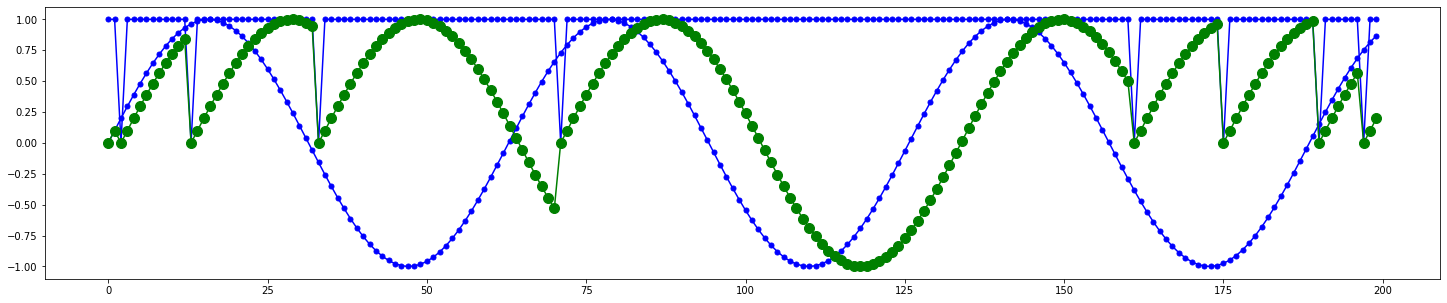

In [5]:
# X:,0 is a... just a sine wave ...
# resets when b equals zero
plt.figure(figsize=(25,5))
display(plt.plot(X[0:200,0],'-bo',markersize=5))
display(plt.plot(X[0:200,1],'-bo',markersize=5))

display(plt.plot(y[0:200],'-go',markersize=10))


### Chuck it in a DF


In [6]:
print(X.shape)
print(y.shape)
df=pd.DataFrame(X, columns=['a','b','c_prev'])
df["y"] = y

df.head(20) # 2*pi 6.28

(10000, 3)
(10000,)


,a,b,c_prev,y
0,0.000000,1.0,0.000000,0.000000
1,0.099843,1.0,0.000000,0.099843
2,0.198689,0.0,0.099843,0.000000
3,0.295549,1.0,0.000000,0.099843
4,0.389455,1.0,0.099843,0.198689
5,0.479469,1.0,0.198689,0.295549
6,0.564692,1.0,0.295549,0.389455
7,0.644271,1.0,0.389455,0.479469
8,0.717412,1.0,0.479469,0.564692
9,0.783383,1.0,0.564692,0.644271


In [ ]:
### Datablock API
# https://docs.fast.ai/data_block.html

## Build a fastai databunch from np array

In [ ]:
# Sample code, not used ...

# split_by_idxs
#  ok, so here split__by_idxs requires 2 collections of indexes ..
# train_idxs = range(0,10)
# val_idxs = range(20,25)
# db1 = FloatList(items=X,ignore_empty=True).\
#      split_by_idxs(train_idx=train_idxs, valid_idx=val_idxs) # .label_from_func(get_float_labels, label_cls=FloatList)

## Databunch.add
# .add(FloatList(items=X))  , add extra data here ...

In [ ]:
# ItemList class has all the goodies and methods implemented.  Look there for code examples
tv_split=range(700,1000)
X=list(zip(a,b))
y=c
# Using Datablocks API
db = FloatList(items=X).split_by_idx(tv_split)._label_from_list(y, label_cls=FloatList)


In [ ]:
#db = FloatList(items=[a,b])
db.train.get(1)
print(db) # .num_parts
mdb = db.databunch()

In [ ]:
mdb.show_batch()

## RNN Example1 - not used .. come back to it

In [ ]:
## Build an RNN

#  import torch.nn as nn
#  
#  n_letters =10
#  n_hidden=5
#  n_categories=3
#  
#  class RNN(nn.Module):
#      def __init__(self, input_size, hidden_size, output_size, tx):
#          super(RNN, self).__init__()
#  
#          self.hidden_size = hidden_size
#  
#          self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#          self.i2o = nn.Linear(input_size + hidden_size, output_size)
#          self.tx = tx
#          self.softmax = nn.LogSoftmax(dim=1)
#  
#      def forward(self, input, hidden):
#          for i in range(tx) :
#              combined = torch.cat((input[i], hidden), 1)
#              hidden = self.i2h(combined)
#              output = self.i2o(combined)
#              output = self.softmax(output)
#          return output, hidden
#  
#      def initHidden(self):
#          return torch.zeros(1, self.hidden_size)
#  
#  bptt=10
#  rnn = RNN(n_letters, n_hidden, n_categories)
#  h=rnn.initHidden()
#  for i in range(bptt) :
#      o, h = rnn(X)
#  


## RNN example 2 using pytorch RNN library

In [7]:
# Initialize with Xavier normal distribuition        
def weights_xavier(m):
    if isinstance(m, nn.Conv2d):
        xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear) :
        xavier_normal_(m.weight.data)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.RNN) :
        xavier_normal_(m.weight_ih_l0.data)
        xavier_normal_(m.weight_hh_l0.data)
        m.bias_ih_l0.data.fill_(0)
        m.bias_hh_l0.data.fill_(0)

### Generic RNN Code Sample

In [8]:
# # initialize the hidden state.
if(0) :
    rnn_model = nn.RNN(num_features, hidden_size, num_layers)  # Input dim is 3, output dim is 3
    final_layer = nn.Linear(hidden_size,1)
    
    rnn_model.apply(weights_xavier)
    
    hidden_rnn = torch.randn(num_layers, batch_size, hidden_size)
    inputs = torch.randn(Tx,batch_size,num_features)
    
    print(inputs.size())
    print(hidden_rnn.size())
    out, hidden = rnn_model(inputs, hidden_rnn)
    o = out[Tx-1].view(-1)
    final_layer(o)

### Instantiate DVRNN

In [9]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html


class DVRNN(nn.Module) :
    def __init__(self,nf,tx,hs,nl) :
        super(DVRNN,self).__init__()
        self.name = "DVRNN"
        self.tx=tx
        self.num_features=nf
        self.hidden_size=hs
        self.rnn = nn.RNN(num_features, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x, h):
        
        out1, hidden = self.rnn(x, h)
        out2 = out1[self.tx-1].view(-1)
        out3 = self.fc(out2)
        return out3,hidden
    
    # reset all parameters of model 
    def init_params(self) :
        self.apply(weights_xavier)

class DVLSTM(nn.Module) :
    def __init__(self,nf,tx,hs,nl) :
        super(DVLSTM,self).__init__()
        self.name = "DVLSTM"
        self.tx=tx
        self.num_features=nf
        self.hidden_size=hs
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x, h):
        
        out1, hidden = self.lstm(x, h)
        out2 = out1[self.tx-1].view(-1)
        out3 = self.fc(out2)
        return out3,hidden
    
    # reset all parameters of model 
    def init_params(self) :
        self.apply(weights_xavier)  

#list(rnn_model.named_parameters())
# Test ...
# dvrnn = DVRNN(num_features,Tx,hidden_size,num_layers)
# dvrnn.init_params()
# print("RNN")
# print(model_summary(dvrnn))
# 
# dvlstm = DVLSTM(num_features,Tx,hidden_size,num_layers)
# dvlstm.init_params()
# print("LSTM")
# print(model_summary(dvlstm))

# #Reshape inputs .  List of 100 1x2 elements to 100 x 1 x 2 ...
# print(inputs[0].size())
# inputs = torch.cat(inputs).view(len(inputs), 1, -1)
# print(inputs.size())
# 
#print("Output  size : {}".format(out.size()))
#print("Hidden (out)  size : {}".format(hidden.size()))

# print(out)
# print(hidden)


## Train RNN

In [23]:
# Build X, y
# Added in time lagged y (c_prev)
torch.manual_seed(0)
NP=1000
Tx = 70          # sequence length 
hidden_size = 3  # number of features of hidden state
num_layers  = 1  # this is for stacked implementations.  Keep 1 for now
batch_size = 1
num_features = 2 # aka input_size, aka number of columns in X


ii,X,y,columns = create_data_set(NP=NP)
X = X[:,0:num_features]


X  = torch.from_numpy(X) #
X  = torch.unsqueeze(X,1).type(torch.FloatTensor)
X = X.to(d)


print("X : {}".format(X.size()))
y = torch.from_numpy(y).type(torch.FloatTensor).to(d)
print("y : {} {}".format(type(y),y.size()))

#hidden_rnn = torch.randn(num_layers, batch_size, hidden_size)
hidden_rnn = torch.zeros(num_layers, batch_size, hidden_size).to(d)
hidden_lstm = (torch.zeros(num_layers, batch_size, hidden_size).to(d),torch.zeros(num_layers, batch_size, hidden_size).to(d))

print("NP           : {}".format(NP))
print("num_features : {}".format(num_features))
print("Tx : {}".format(Tx))
print("hidden_size : {}".format(hidden_size))
print("num_layers : {}".format(num_layers))
print("batch_size : {}".format(batch_size))
print("X size : {}".format(X.size()))
print("y size : {}".format(y.size()))


Creating Dataset : Num Points = 1000 Reset prob = 0.05
Sine wave with 1000 samples over x range of 100
X : torch.Size([1000, 1, 2])
y : <class 'torch.Tensor'> torch.Size([1000])
NP           : 1000
num_features : 2
Tx : 70
hidden_size : 3
num_layers : 1
batch_size : 1
X size : torch.Size([1000, 1, 2])
y size : torch.Size([1000])


In [24]:
# Setup Custom RNN
torch.manual_seed(1)

dvrnn = DVRNN(num_features,Tx,hidden_size,num_layers).to(d)
dvrnn.init_params()

dvlstm = DVLSTM(num_features,Tx,hidden_size,num_layers).to(d)
dvlstm.init_params()

#dvrnn.train()
#optimizer = optim.SGD(dvrnn.parameters(), lr=0.1)
loss_function = nn.MSELoss()  # L1Loss



In [26]:
#print(list(dvlstm.lstm.named_parameters()))
#dvlstm.lstm.weight_hh_l0.grad
def lstm_wg_stats() :
    
    h = "{:<15s} {:<10s} {:<10s} {:<10s} {:<10s}".format("layer", "wght mean", "wght std", "grad mean", "grad std")
    print(h)
    for layer,values in list(dvlstm.lstm.named_parameters()) :
        #print(layer)
        #print(values.view(-1).mean())
        #print(values.view(-1).std())
        #print(values.grad.view(-1).mean())
        #print(values.grad.view(-1).std())
        h = "{:<15s} {:10.4f} {:10.4f} {:10.4f} {:10.4f}".format(layer, values.view(-1).mean(),values.view(-1).std(),values.grad.view(-1).mean(),values.grad.view(-1).std())
        print(h)
        
lstm_wg_stats()

layer           wght mean  wght std   grad mean  grad std  
weight_ih_l0       -0.4338     0.8657     1.1416     2.9425
weight_hh_l0       -0.0052     0.9927    -0.1311     0.8225
bias_ih_l0         -0.4241     0.9262     1.1073     4.3790
bias_hh_l0         -0.3040     0.9238     1.1073     4.3790


In [ ]:
# Train
# 10 epoch @ 0.01
# 10 epoch @ 0.001
#optimizer = optim.Adam(dvrnn.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer_rnn = optim.Adam(dvrnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer_lstm = optim.Adam(dvlstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

def train_instance(iteration, model, opt, hidden_init) :
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    dvrnn.zero_grad()
        
    # Build my X,y for the batch ...
    x_tx = X[iteration:iteration+Tx]
    y_tx = y[iteration+Tx].view(-1)
    #print(x_tx.size())
    #print(y_tx.size())
    #print(hidden_rnn.size())
    #print(y_tx)
    #print(x_tx)
    
    # Step 3. Run our forward pass.
    #print("hidden_rnn: {}".format(hidden_rnn))
    yhat, _ = model(x_tx, hidden_init)
    #print(hidden_rnn1.size())
    #print("yhat.size: {}".format(yhat.size()))

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_function(yhat, y_tx)
    #print("yhat:{} y_tx:{} loss:{}".format(yhat, y_tx, loss))
    loss.backward()
    opt.step()
    #print(list(dvrnn.parameters())[0].grad)
    return loss.item()

    
for epoch in range(15):  # again, normally you would NOT do 300 epochs, it is toy data
    epoch_rnn_loss=epoch_lstm_loss=0
    for i in range(NP-dvrnn.tx-1):#
        #print("Iteration: {} {}".format(epoch,i))

        epoch_rnn_loss += train_instance(i,dvrnn,optimizer_rnn,hidden_rnn)
        epoch_lstm_loss += train_instance(i,dvlstm,optimizer_lstm,hidden_lstm)
    # Normalize per training example
    epoch_rnn_loss /= (NP-dvrnn.tx)
    epoch_lstm_loss /= (NP-dvrnn.tx)
    print("Epoch {} loss: RNN {} LSTM {}".format(epoch, epoch_rnn_loss,epoch_lstm_loss))
    lstm_wg_stats()
    #print(dvrnn.rnn.weight_hh_l0.grad)
    #print(dvrnn.rnn.weight_hh_l0.data)
print(list(dvrnn.parameters()))

In [ ]:
# Add GRU
# Add Validation

i=192
for i in range(100,200):
    x_tx = X[i:i+dvrnn.tx]
    y[i+dvrnn.tx]
    yhat, _ = dvrnn(x_tx, hidden_rnn)
    print(yhat,y[i+dvrnn.tx],X[i+dvrnn.tx])

In [ ]:
list(dvrnn.parameters())[0]

In [ ]:
dvrnn.rnn.weight_hh_l0.grad

In [ ]:
# lstm ...
#lstm = nn.LSTM(3, 3)  # Input/Embedding dim is 3, output dim is 3, 
#hidden = (torch.randn(1, 1, 3),
#          torch.randn(1, 1, 3))


In [ ]:
rnn=nn.RNN(3,3)
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputs

In [ ]:
# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
hidden

In [ ]:
print(inputs[0])
print(inputs[0].view(1,1,-1)) # just adds a dimension! unsqueeze

In [ ]:
#https://johaupt.github.io/python/fastai/pytorch/fastai_custom_network_module.html


In [ ]:
from fastai.basic_train import *
from fastai.metrics import *
learner = Learner(data=mdb, model=rnn, loss_func=nn.MSELoss()) # ,metrics=accuracy)


In [ ]:
#learner.lr_find()
learner.model

In [ ]:
doc(cnn_learner)